# Importing Libraries 

In [1]:
import pandas as pd 
import tensorflow as tf 
from keras.layers import Input, Dense 
from keras.models import Model 
from sklearn.metrics import precision_recall_fscore_support 
import matplotlib.pyplot as plt 


# Data Pre-Processing and Cleaning

In [2]:
data = pd.read_csv( '/Users/saikarthik/Desktop/Nexus-S1 Deakin /machine_temperature_system_failure.csv') 

In [3]:
data.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [4]:

data_values = data.drop('timestamp', axis=1).values 

In [5]:
data_values = data_values.astype('float32') 

In [6]:
df= pd.DataFrame(data_values, columns=data.columns[1:]) 



In [7]:
df.insert(0, 'timestamp', data['timestamp']) 

In [8]:
df.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967323
1,2013-12-02 21:20:00,74.935883
2,2013-12-02 21:25:00,76.124161
3,2013-12-02 21:30:00,78.140709
4,2013-12-02 21:35:00,79.329834


In [9]:
df.isnull().sum()

timestamp    0
value        0
dtype: int64

In [13]:
df.to_csv("cleaned.csv")

# Exploratory Data Analysis 

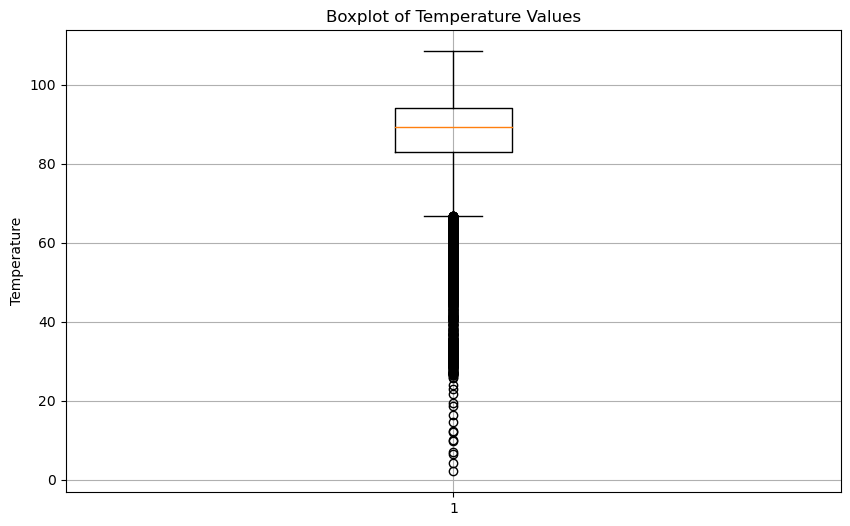

count    22695.000000
mean        85.926498
std         13.746907
min          2.084721
25%         83.080078
50%         89.408249
75%         94.016254
max        108.510544
Name: value, dtype: float64 85.92649821068021 89.40824624 13.746912473090113


In [10]:

summary_statistics = df['value'].describe()

mean_value = data['value'].mean()
median_value = data['value'].median()
std_dev_value = data['value'].std()



plt.figure(figsize=(10, 6))
plt.boxplot(data['value'])
plt.title('Boxplot of Temperature Values')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()

print(summary_statistics, mean_value, median_value, std_dev_value)


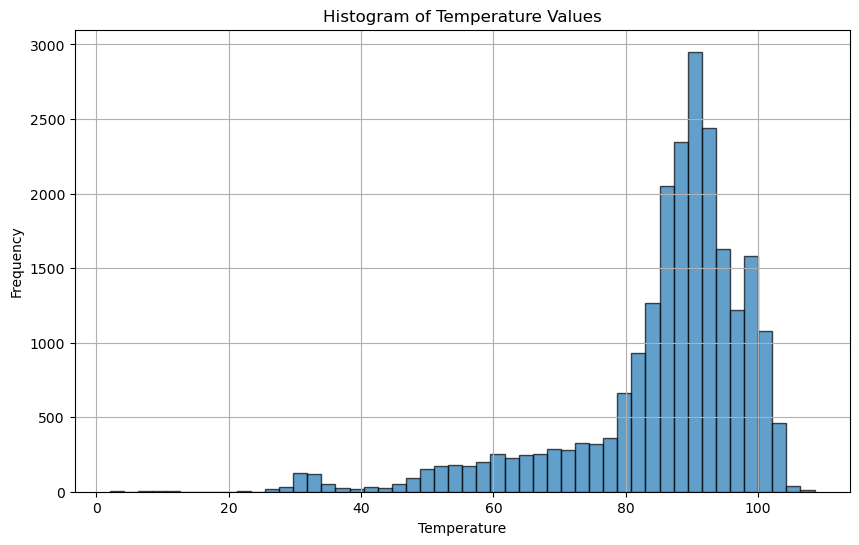

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(data['value'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Temperature Values')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

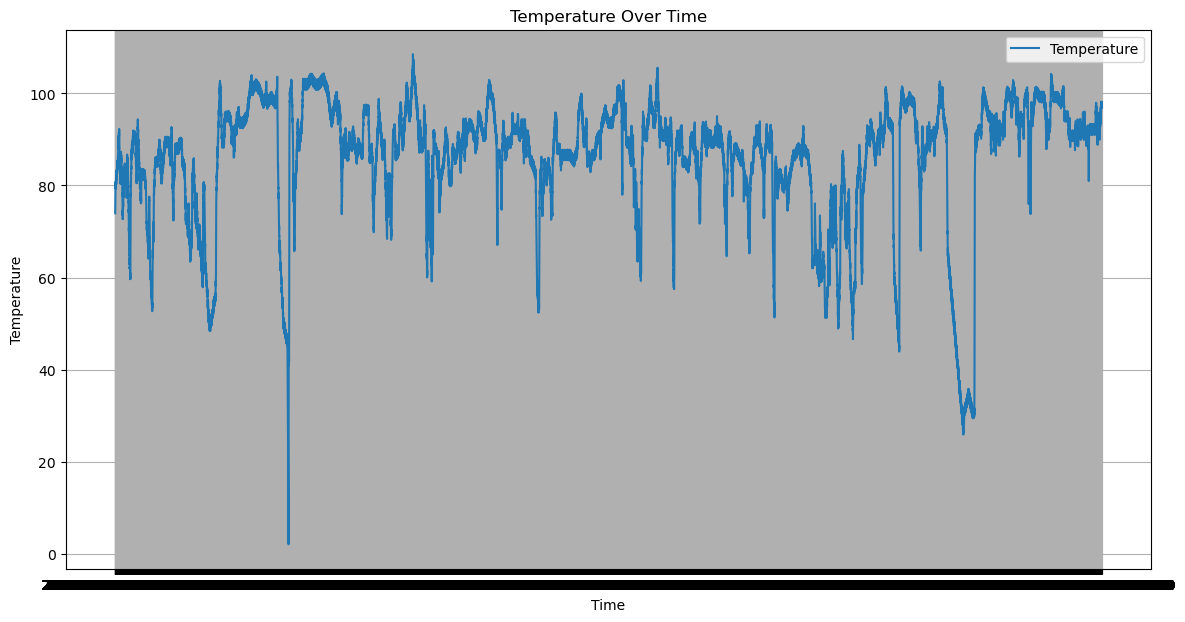

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(df['timestamp'], df['value'], label='Temperature')
plt.title('Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()